<a href="https://colab.research.google.com/github/rkti498/e_shikaku/blob/main/day12_02_modified_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 02 改善したネットワーク
### サンプルコードをもとにMNIST学習モデルを作成
### レイヤーとネットワークをクラス化して実装を簡潔かつ汎用的に改善。


In [ ]:
# !pip install tensorflow==2.3.1

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import OrderedDict

In [ ]:
try:
    import urllib.request
except ImportError:
    raise ImportError('You should use Python 3.x')
import os.path
import gzip
import pickle
import os
import numpy as np


url_base = 'http://yann.lecun.com/exdb/mnist/'
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

dataset_dir = os.path.dirname(os.path.abspath("__file__"))
save_file = dataset_dir + "/mnist.pkl"

train_num = 60000
test_num = 10000
img_dim = (1, 28, 28)
img_size = 784


def _download(file_name):
    file_path = dataset_dir + "/" + file_name
    
    if os.path.exists(file_path):
        return

    print("Downloading " + file_name + " ... ")
    urllib.request.urlretrieve(url_base + file_name, file_path)
    print("Done")
    
def download_mnist():
    for v in key_file.values():
       _download(v)
        
def _load_label(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            labels = np.frombuffer(f.read(), np.uint8, offset=8)
    print("Done")
    
    return labels

def _load_img(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")    
    with gzip.open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, img_size)
    print("Done")
    
    return data
    
def _convert_numpy():
    dataset = {}
    dataset['train_img'] =  _load_img(key_file['train_img'])
    dataset['train_label'] = _load_label(key_file['train_label'])    
    dataset['test_img'] = _load_img(key_file['test_img'])
    dataset['test_label'] = _load_label(key_file['test_label'])
    
    return dataset

def init_mnist():
    download_mnist()
    dataset = _convert_numpy()
    print("Creating pickle file ...")
    with open(save_file, 'wb') as f:
        pickle.dump(dataset, f, -1)
    print("Done!")

def _change_one_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
        
    return T
    

def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    """MNISTデータセットの読み込み
    
    Parameters
    ----------
    normalize : 画像のピクセル値を0.0~1.0に正規化する
    one_hot_label : 
        one_hot_labelがTrueの場合、ラベルはone-hot配列として返す
        one-hot配列とは、たとえば[0,0,1,0,0,0,0,0,0,0]のような配列
    flatten : 画像を一次元配列に平にするかどうか 
    
    Returns
    -------
    (訓練画像, 訓練ラベル), (テスト画像, テストラベル)
    """
    if not os.path.exists(save_file):
        init_mnist()
        
    with open(save_file, 'rb') as f:
        dataset = pickle.load(f)
    
    if normalize:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].astype(np.float32)
            dataset[key] /= 255.0
            
    if one_hot_label:
        dataset['train_label'] = _change_one_hot_label(dataset['train_label'])
        dataset['test_label'] = _change_one_hot_label(dataset['test_label'])
    
    if not flatten:
         for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

    return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label']) 


if __name__ == '__main__':
    init_mnist()

Done
Done
Done
Done
Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!


In [ ]:
class Funcs:

  # 中間層の活性化関数
  # シグモイド関数（ロジスティック関数）
  def sigmoid(self, x):
      return 1/(1 + np.exp(-x))

  # ReLU関数
  def relu(self, x):
      return np.maximum(0, x)

  # ステップ関数（閾値0）
  def step_function(self, x):
      return np.where( x > 0, 1, 0) 

  # 出力層の活性化関数
  # ソフトマックス関数
  def softmax(self, x):
      if x.ndim == 2:
          x = x.T
          x = x - np.max(x, axis=0)
          y = np.exp(x) / np.sum(np.exp(x), axis=0)
          return y.T

      x = x - np.max(x) # オーバーフロー対策
      return np.exp(x) / np.sum(np.exp(x))

  # ソフトマックスとクロスエントロピーの複合関数
  def softmax_with_loss(self, d, x):
      y = softmax(x)
      return cross_entropy_error(d, y)

  # 誤差関数
  # 平均二乗誤差
  def mean_squared_error(self, d, y):
      return np.mean(np.square(d - y)) / 2

  # クロスエントロピー
  def cross_entropy_error(self, d, y):
      if y.ndim == 1:
          d = d.reshape(1, d.size)
          y = y.reshape(1, y.size)
          
      # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
      if d.size == y.size:
          d = d.argmax(axis=1)
              
      batch_size = y.shape[0]
      return -np.sum(np.log(y[np.arange(batch_size), d] + 1e-7)) / batch_size



  # 活性化関数の導関数
  # シグモイド関数（ロジスティック関数）の導関数
  def d_sigmoid(self, x):
      dx = (1.0 - sigmoid(x)) * sigmoid(x)
      return dx

  # ReLU関数の導関数
  def d_relu(self, x):
      return np.where( x > 0, 1, 0)
      
  # ステップ関数の導関数
  def d_step_function(self, x):
      return 0

  # 平均二乗誤差の導関数
  def d_mean_squared_error(self, d, y):
      if type(d) == np.ndarray:
          batch_size = d.shape[0]
          dx = (y - d)/batch_size
      else:
          dx = y - d
      return dx


  # ソフトマックスとクロスエントロピーの複合導関数
  def d_softmax_with_loss(self, d, y):
      batch_size = d.shape[0]
      if d.size == y.size: # 教師データがone-hot-vectorの場合
          dx = (y - d) / batch_size
      else:
          dx = y.copy()
          dx[np.arange(batch_size), d] -= 1
          dx = dx / batch_size
      return dx

  # シグモイドとクロスエントロピーの複合導関数
  def d_sigmoid_with_loss(self, d, y):
      return y - d

  # # 数値微分
  # def numerical_gradient(self, f, x):
  #     h = 1e-4
  #     grad = np.zeros_like(x)

  #     for idx in range(x.size):
  #         tmp_val = x[idx]
  #         # f(x + h)の計算
  #         x[idx] = tmp_val + h
  #         fxh1 = f(x)

  #         # f(x - h)の計算
  #         x[idx] = tmp_val - h
  #         fxh2 = f(x)

  #         grad[idx] = (fxh1 - fxh2) / (2 * h)
  #         # 値を元に戻す
  #         x[idx] = tmp_val

  #     return grad

In [ ]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col


def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

In [ ]:

funcs = Funcs()
print(funcs.relu([-3, -2, -1, 0, 1, 2, 3]))


[0 0 0 0 1 2 3]


In [ ]:
# ReLU layer
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        # mask.shape = x.shape
        # True or Falseを要素として持つ
        self.mask = (x <= 0)
        out = x.copy()
        # Trueの箇所を0にする
        out[self.mask] = 0

        return out

    def backward(self, dout):
        # Trueの箇所を0にする
        dout[self.mask] = 0
        dx = dout

        return dx
    
# Affine layer(全結合 layer)
class Affine:
    
    def __init__(self, W, b):
        self.W =W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 重み・バイアスパラメータの微分
        self.dW = None
        self.db = None

    def forward(self, x):
        # テンソル対応        
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x
        out = np.dot(self.x, self.W) + self.b
        
        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

        return dx

class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # softmaxの出力
        self.d = None # 教師データ

    def forward(self, x, d):
        self.d = d
        self.y = funcs.softmax(x)
        self.loss = funcs.cross_entropy_error(self.d, self.y)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.d.shape[0]
        if self.d.size == self.y.size: # 教師データがone-hot-vectorの場合
            dx = (self.y - self.d) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.d] -= 1
            dx = dx / batch_size
        
        return dx

## MNISTを試す

In [ ]:
class TwoLayerNet:
    '''
    input_size: 入力層のノード数
    hidden_size: 隠れ層のノード数
    output_size: 出力層のノード数
    weight_init_std: 重みの初期化方法
    '''
    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['b2'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        
        self.lastLayer = SoftmaxWithLoss()
        
    # 順伝播
    def predict(self, x):
        for layer in self.layers.values():
            # print("predictのx", x)
            x = layer.forward(x)
        
        return x
        
    # 誤差
    def loss(self, x, d):
        y = self.predict(x)
        return self.lastLayer.forward(y, d)
    
    # 精度
    def accuracy(self, x, d):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if d.ndim != 1 : d = np.argmax(d, axis=1)
        
        accuracy = np.sum(y == d) / float(x.shape[0])
        return accuracy
             
    # 勾配
    def gradient(self, x, d):
        # forward

        self.loss(x, d)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grad = {}
        grad['W1'], grad['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grad['W2'], grad['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grad

データ読み込み完了
Generation: 100. 正答率(トレーニング) = 0.78
                : 100. 正答率(テスト) = 0.7116
Generation: 200. 正答率(トレーニング) = 0.92
                : 200. 正答率(テスト) = 0.8526
Generation: 300. 正答率(トレーニング) = 0.92
                : 300. 正答率(テスト) = 0.8808
Generation: 400. 正答率(トレーニング) = 0.88
                : 400. 正答率(テスト) = 0.8974
Generation: 500. 正答率(トレーニング) = 0.9
                : 500. 正答率(テスト) = 0.8984
Generation: 600. 正答率(トレーニング) = 0.91
                : 600. 正答率(テスト) = 0.906
Generation: 700. 正答率(トレーニング) = 0.97
                : 700. 正答率(テスト) = 0.9073
Generation: 800. 正答率(トレーニング) = 0.91
                : 800. 正答率(テスト) = 0.9115
Generation: 900. 正答率(トレーニング) = 0.92
                : 900. 正答率(テスト) = 0.9154
Generation: 1000. 正答率(トレーニング) = 0.95
                : 1000. 正答率(テスト) = 0.9171
Generation: 1100. 正答率(トレーニング) = 0.88
                : 1100. 正答率(テスト) = 0.9218
Generation: 1200. 正答率(トレーニング) = 0.93
                : 1200. 正答率(テスト) = 0.9234
Generation: 1300. 正答率(トレーニング) = 0.93
                : 1300. 正

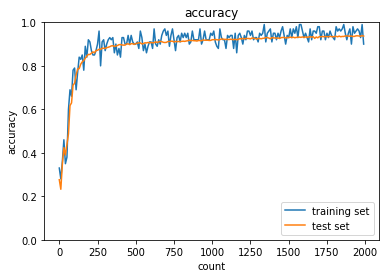

In [ ]:


# データの読み込み
# (x_train, d_train), (x_test, d_test) = tf.keras.datasets.mnist.load_data()
# print(x_train[50])

# MNISTデータを加工する
# x_train  = x_train.reshape(60000, 784)
# x_test   = x_test.reshape(10000, 784)
# x_train  = x_train.astype('float32')
# x_test   = x_test.astype('float32')
# x_train /= 255
# x_test  /= 255
# d_train  = tf.keras.utils.to_categorical(d_train, 10)
# d_test   = tf.keras.utils.to_categorical(d_test, 10)

(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)
# print(x_train[50])

print("データ読み込み完了")

network = TwoLayerNet(input_size=784, hidden_size=40, output_size=10)
# print(network.params['W1'])

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # print(type(x_batch))

    # 勾配
    grad = network.gradient(x_batch, d_batch)
    
    for key in ('W1', 'W2', 'b1', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)
    
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)

        if (i + 1) % (plot_interval * 10) == 0:
            print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
            print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

## 考察
ディープラーニングの実装の典型例を確認。
ネットワークのpredict、gradientから、それぞれ各レイヤーのforward、backwardをループ実行することで柔軟にモデルを作成できる。